
# **Veille Technique : Utilisation Avancée du Modèle sentence-transformers all-MiniLM-L6-v2**





Pour élaborer ce Notebook, nous avons consulté des sources d'informations reconnues et récentes. Parmi celles-ci, Arxiv et Google Scholar sont des références pour les prépublications et les articles de recherche. Des blogs et sites web renommés comme FastML, Machine Learning Mastery, KDnuggets, Import AI, et MIT Technology Review fournissent des analyses et des tutoriels approfondis sur l'apprentissage automatique et la science des données.

Parmi les modèles que nous avons trouvés :

**TinyBERT: Distilling BERT for Natural Language Understanding**

Référence: Jiao, X., Yin, Y., Shang, L., Jiang, X., Chen, X., Li, L., Wang, F., & Liu, Q. (2020). TinyBERT: Distilling BERT for Natural Language Understanding. arXiv preprint arXiv:1909.10351.

**MobileBERT: a Compact Task-Agnostic BERT for Resource-Limited Devices**

Référence: Sun, Z., Yu, H., Song, X., Liu, R., Yang, Y., & Zhou, D. (2020). MobileBERT: a Compact Task-Agnostic BERT for Resource-Limited Devices. Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics, 2158-2170.

**ALBERT: A Lite BERT for Self-supervised Learning of Language Representations**

Référence: Lan, Z., Chen, M., Goodman, S., Gimpel, K., Sharma, P., & Soricut, R. (2020). ALBERT: A Lite BERT for Self-supervised Learning of Language Representations. International Conference on Learning Representations.

**DistilRoBERTa: a Distilled Version of RoBERTa**

Référence: Liu, Y., Ott, M., Goyal, N., Du, J., Joshi, M., Chen, D., Levy, O., Lewis, M., Zettlemoyer, L., & Stoyanov, V. (2020). RoBERTa: A Robustly Optimized BERT Pretraining Approach. arXiv preprint arXiv:1907.11692.

Après avoir examiné plusieurs modèles récents, nous avons choisi **MiniLM: Deep Self-Attention Distillation for Task-Agnostic Compression of Pre-Trained Transformers** pour notre analyse.

Référence: Wang, W., Wei, F., Dong, L., Bao, H., Yang, N., & Zhou, M. (2020). MiniLM: Deep Self-Attention Distillation for Task-Agnostic Compression of Pre-Trained Transformers. arXiv preprint arXiv:2002.10957.

Introduction
Problème: Les modèles de transformateurs pré-entraînés, tels que BERT, RoBERTa, et GPT-2, sont extrêmement puissants mais nécessitent beaucoup de ressources pour l'inférence en raison de leur taille importante (centaines de millions de paramètres).
Solution Proposée: MiniLM, une méthode de distillation de l'attention auto-régulée pour compresser les modèles de transformateurs de manière agnostique aux tâches.
Contributions Principales
Distillation de l'Attention Profonde:
MiniLM distille l'attention multi-tête (Multi-Head Attention) des modèles enseignants aux modèles étudiants. La distillation se concentre spécifiquement sur le module d'attention de la dernière couche du modèle enseignant.
Introduction de la Relation de Valeurs:
En plus de la distribution d'attention (produit scalaire des requêtes et clés), MiniLM introduit le produit scalaire des valeurs dans le module d'attention comme nouvelle connaissance de distillation.
Assistant Enseignant:
L'introduction d'un assistant enseignant aide également à la distillation de grands modèles de transformateurs pré-entraînés, en particulier lorsque l'écart de taille entre le modèle enseignant et le modèle étudiant est important.
Méthodologie
Distillation de la Distribution de l'Attention:

Formule de l'Attention Multi-Tête:


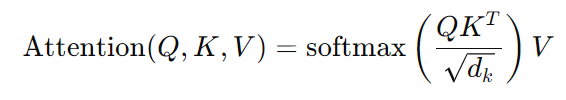


où 𝑄, 𝐾, et 𝑉 représentent respectivement les matrices de requête, de clé et de valeur, et 𝑑 𝑘  est la dimension des clés.

Perte de Distillation de la Distribution d'Attention:

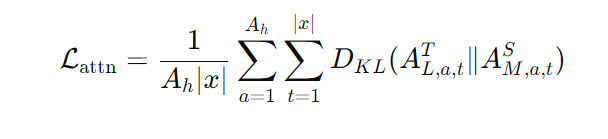

où  𝐴ℎ est le nombre de têtes d'attention, ∣x∣ est la longueur de la séquence,
𝐿 et 𝑀 sont le nombre de couches pour l'enseignant et l'étudiant respectivement, et 𝐴 représente les distributions d'attention.

Transfert de la Relation de Valeurs:

Formule du Produit Scalaire des Valeurs:

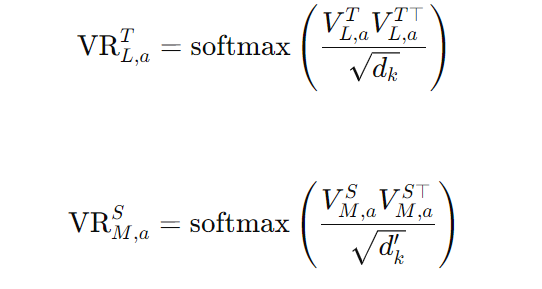

Perte de Distillation de la Relation de Valeurs:


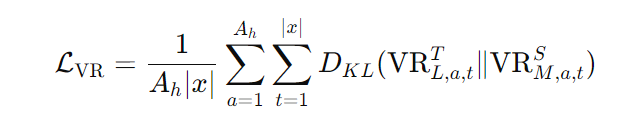

Assistant Enseignant:

Un modèle assistant est introduit pour faciliter la distillation lorsque l'écart de taille entre l'enseignant et l'étudiant est important. L'assistant aide à réduire progressivement cet écart, améliorant ainsi la performance de l'étudiant final.

Résultats Expérimentaux
Jeux de Données Utilisés: GLUE, SQuAD, et autres tâches standardisées de NLP.
Performance:
MiniLM atteint des performances comparables à celles des modèles enseignants tout en utilisant seulement 50% des paramètres et des ressources de calcul. Par exemple, le modèle MiniLM conserve plus de 99% de précision sur SQuAD 2.0 et plusieurs tâches de référence GLUE.

Conclusion
MiniLM propose une méthode efficace et généralisable pour compresser les modèles de transformateurs pré-entraînés sans compromettre la performance. La distillation de l'attention auto-régulée et le transfert de la relation de valeurs se révèlent être des techniques puissantes pour la compression des grands modèles de transformateurs, ouvrant la voie à des applications en temps réel sur des appareils à ressources limitées.

# Implémentation de MiniLM
---



In [6]:
!pip install sentence-transformers
!pip install umap-learn
!pip install shap

In [7]:
# Imports nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, gc, time
from sklearn import manifold, decomposition
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sentence_transformers import SentenceTransformer
import torch
import umap
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# Charger les données
data = pd.read_csv('/content/flipkart_com-ecommerce_sample_1050.csv')

In [9]:
# Fonctions de prétraitement des textes
def tokenizer_fct(sentence):
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words):
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

def lower_start_fct(list_words):
    lw = [w.lower() for w in list_words if (not w.startswith("@")) and (not w.startswith("http"))]
    return lw

def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

def transform_dl_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

data['pro_desc'] = data['product_name'].str.cat(data['description'], sep=" ")
data['pro_desc_dl'] = data['pro_desc'].apply(lambda x: transform_dl_fct(x))

In [10]:
# Préparer les données pour sentence-transformers/all-MiniLM-L6-v2
sentences = data['pro_desc_dl'].tolist()
data['categorie'] = data['product_category_tree'].apply(lambda x: x.split(' >>')[0].split('["')[1])

In [11]:
# Charger le modèle sentence-transformers/all-MiniLM-L6-v2
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Fonction pour extraire les caractéristiques avec sentence-transformers/all-MiniLM-L6-v2
def feature_extraction(model, sentences, batch_size=8):
    return model.encode(sentences, batch_size=batch_size, show_progress_bar=True)

# Extraire les caractéristiques
features = feature_extraction(model, sentences)

Batches:   0%|          | 0/132 [00:00<?, ?it/s]

In [12]:
# Normalisation des caractéristiques
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Réduction de dimensionnalité avec PCA puis UMAP
pca = decomposition.PCA(n_components=50, random_state=42)
features_pca = pca.fit_transform(features_scaled)

umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.05, metric='cosine', random_state=42)
X_umap = umap_reducer.fit_transform(features_pca)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [13]:
# Création d'un DataFrame avec les données UMAP
df_umap = pd.DataFrame(X_umap, columns=['umap1', 'umap2'])
df_umap["category"] = data['categorie']

# Clustering avec KMeans
num_labels = data['categorie'].nunique()

# Utilisation de GridSearchCV pour optimiser les hyperparamètres de KMeans
param_grid = {
    'n_clusters': [num_labels, num_labels+2, num_labels-2],
    'n_init': [10, 50, 100],
    'max_iter': [300, 600, 1000],
    'random_state': [42]

}

kmeans = KMeans()
grid_search = GridSearchCV(kmeans, param_grid, cv=5, scoring='adjusted_rand_score')
grid_search.fit(X_umap, data['categorie'])
best_kmeans = grid_search.best_estimator_

df_umap['cluster'] = best_kmeans.labels_

In [14]:
# Calcul de l'ARI pour sentence-transformers/all-MiniLM-L6-v2
y_cat_num = data['categorie'].values
ARI = np.round(metrics.adjusted_rand_score(y_cat_num, df_umap['cluster']), 4)
print("Score ARI approche sentence-transformers/all-MiniLM-L6-v2 : ", ARI)

Score ARI approche sentence-transformers/all-MiniLM-L6-v2 :  0.5347


In [15]:
!pip install shap

Pour utiliser MiniLM dans le contexte de l'interprétabilité globale et locale, nous devons d'abord comprendre comment MiniLM fonctionne. MiniLM est un modèle distillé de transformateurs pré-entraînés qui est conçu pour être plus léger tout en conservant une performance comparable. Il est particulièrement utilisé pour les tâches de traitement du langage naturel (NLP).

Pour l'interprétabilité globale et locale, nous allons utiliser des techniques comme SHAP (SHapley Additive exPlanations) ou LIME (Local Interpretable Model-agnostic Explanations) qui peuvent être appliquées à des modèles basés sur des transformateurs. Nous utiliserons MiniLM pour extraire les embeddings des textes et ensuite appliquer un modèle de clustering comme KMeans pour analyser les clusters.

Ensuite, nous appliquerons SHAP pour expliquer les prédictions du modèle de clustering.

# Echantillon pour faire feature importance locale et global

In [19]:
# Importations nécessaires
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import shap
import matplotlib.pyplot as plt

# Charger les données
data = pd.read_csv('/content/flipkart_com-ecommerce_sample_1050.csv')

# Charger le modèle MiniLM
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Fonction pour extraire les caractéristiques avec MiniLM
def feature_extraction(model, sentences, batch_size=8):
    return model.encode(sentences, batch_size=batch_size, show_progress_bar=True)

# Préparer les données
data['pro_desc'] = data['product_name'].str.cat(data['description'], sep=" ")
sentences = data['pro_desc'].tolist()
features = feature_extraction(model, sentences)

# Normalisation des caractéristiques
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Clustering avec KMeans
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')  # Ajuster le nombre de clusters selon votre cas
kmeans.fit(features_scaled)
labels = kmeans.labels_

# Ajouter les clusters au dataframe
data['cluster'] = labels


Batches:   0%|          | 0/132 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Total number of features: 384
Dimensions of features_scaled_sample: (100, 384)
Dimensions of feature_importances_sample: (384,)
Dimensions of top_indices: (20,)
Dimensions of top_features: (100, 20)


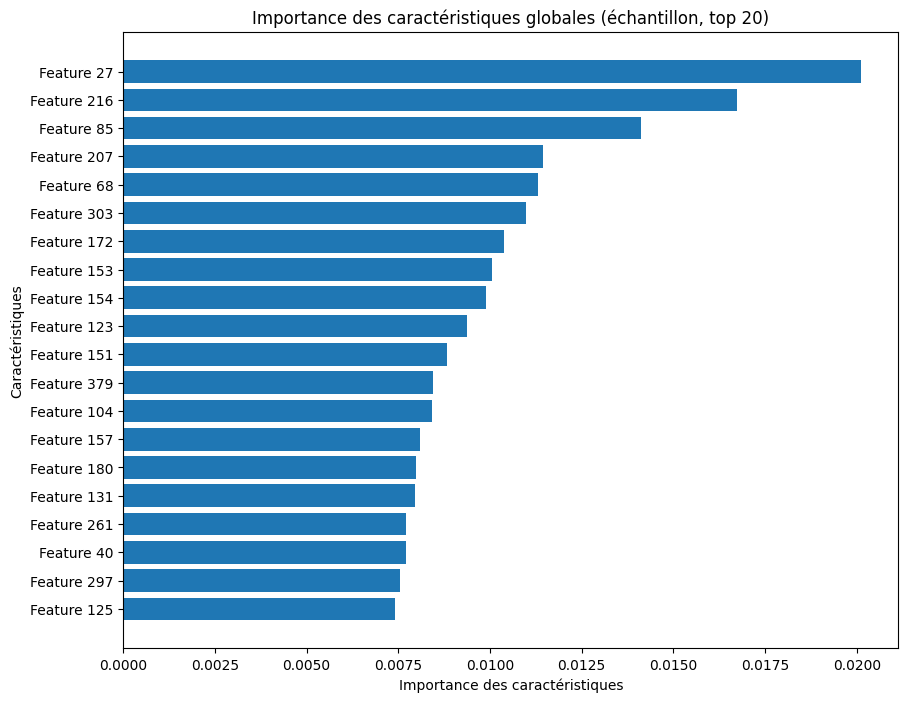

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Score ARI approche sentence-transformers/all-MiniLM-L6-v2 (échantillon) :  0.5542
Dimensions des SHAP values : (100, 384, 7)
Dimensions of selected_shap_values: (100, 20, 7)


In [27]:
# Sélectionner un échantillon de 100 lignes (vous pouvez ajuster la taille de l'échantillon selon vos besoins)
data_sample = data.sample(n=100, random_state=42)

# Appliquer les mêmes transformations sur cet échantillon
data_sample['pro_desc'] = data_sample['product_name'].str.cat(data_sample['description'], sep=" ")
data_sample['pro_desc_dl'] = data_sample['pro_desc'].apply(lambda x: transform_dl_fct(x))
sentences_sample = data_sample['pro_desc_dl'].tolist()
data_sample['categorie'] = data_sample['product_category_tree'].apply(lambda x: x.split(' >>')[0].split('["')[1])

# Extraire les caractéristiques pour l'échantillon
features_sample = feature_extraction(model, sentences_sample)

# Normalisation des caractéristiques
scaler = StandardScaler()
features_scaled_sample = scaler.fit_transform(features_sample)

# Vérifier le nombre total de caractéristiques
total_features = features_scaled_sample.shape[1]
print(f"Total number of features: {total_features}")

# Importance des caractéristiques globales avec Random Forest sur l'échantillon
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(features_scaled_sample, data_sample['categorie'])
feature_importances_sample = rf_model.feature_importances_

# Adapter le nombre de caractéristiques les plus importantes en fonction du nombre total disponible
top_n = min(20, total_features)
top_indices = np.argsort(feature_importances_sample)[-top_n:]
top_features = features_scaled_sample[:, top_indices]

# Vérifier les dimensions des variables intermédiaires
print(f"Dimensions of features_scaled_sample: {features_scaled_sample.shape}")
print(f"Dimensions of feature_importances_sample: {feature_importances_sample.shape}")
print(f"Dimensions of top_indices: {top_indices.shape}")
print(f"Dimensions of top_features: {top_features.shape}")

# Visualiser l'importance des caractéristiques globales pour l'échantillon (les meilleures caractéristiques)
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), feature_importances_sample[top_indices], align='center')
plt.yticks(range(top_n), [f'Feature {i+1}' for i in top_indices])
plt.xlabel('Importance des caractéristiques')
plt.ylabel('Caractéristiques')
plt.title(f'Importance des caractéristiques globales (échantillon, top {top_n})')
plt.show()

# Réduction de dimensionnalité avec PCA puis UMAP pour l'échantillon
pca_sample = decomposition.PCA(n_components=50, random_state=42)
features_pca_sample = pca_sample.fit_transform(features_scaled_sample)

umap_reducer_sample = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.05, metric='cosine', random_state=42)
X_umap_sample = umap_reducer_sample.fit_transform(features_pca_sample)

# Création d'un DataFrame avec les données UMAP pour l'échantillon
df_umap_sample = pd.DataFrame(X_umap_sample, columns=['umap1', 'umap2'])
df_umap_sample["category"] = data_sample['categorie']

# Clustering avec KMeans pour l'échantillon
num_labels_sample = data_sample['categorie'].nunique()

# Utilisation de GridSearchCV pour optimiser les hyperparamètres de KMeans pour l'échantillon
param_grid = {
    'n_clusters': [num_labels_sample, num_labels_sample+2, num_labels_sample-2],
    'n_init': [10, 50, 100],
    'max_iter': [300, 600, 1000],
    'random_state': [42]
}

kmeans_sample = KMeans()
grid_search_sample = GridSearchCV(kmeans_sample, param_grid, cv=5, scoring='adjusted_rand_score')
grid_search_sample.fit(X_umap_sample, data_sample['categorie'])
best_kmeans_sample = grid_search_sample.best_estimator_

df_umap_sample['cluster'] = best_kmeans_sample.labels_

# Calcul de l'ARI pour sentence-transformers/all-MiniLM-L6-v2 sur l'échantillon
y_cat_num_sample = data_sample['categorie'].values
ARI_sample = np.round(metrics.adjusted_rand_score(y_cat_num_sample, df_umap_sample['cluster']), 4)
print("Score ARI approche sentence-transformers/all-MiniLM-L6-v2 (échantillon) : ", ARI_sample)

# Analyse des caractéristiques locales avec SHAP pour l'échantillon (les meilleures caractéristiques)
explainer_sample = shap.Explainer(rf_model, features_scaled_sample)
shap_values_sample = explainer_sample(features_scaled_sample)

# Vérifier la dimension des SHAP values
print(f"Dimensions des SHAP values : {shap_values_sample.values.shape}")

# Utiliser les indices corrects pour les SHAP values
selected_shap_values = shap_values_sample.values[:, top_indices, :]

# Vérifier les dimensions après la sélection des SHAP values
print(f"Dimensions of selected_shap_values: {selected_shap_values.shape}")

# Visualiser les valeurs SHAP pour un exemple particulier dans l'échantillon (les meilleures caractéristiques)
shap.initjs()
shap.force_plot(explainer_sample.expected_value[0], selected_shap_values[0][:, 0], top_features[0], feature_names=[f'Feature {i+1}' for i in top_indices])
